In [114]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import Random
from time import time
from inspyred import ec, benchmarks
from collections import Counter

## Problem Class Definition

In [ ]:
class WorkoutRoutine(benchmarks.Benchmark):
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        self.userLevel = userLevel.lower()
        self.time = time  # horas
        self.exercises = exercises  # diccionario {id: ejercicio}
        self.length = time * 6  # máx 6 ejercicios por hora
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        self.maximize = True
        self.bounder = ec.DiscreteBounder([1, 3005])

        self.difficulty_map = {
            "beginner": 0,
            "novice": 1,
            "intermediate": 2,
            "advanced": 3,
            "expert": 4,
            "master": 5
        }


    def generator(self, random, args):
        def clean_equipment(val):
            return str(val).strip().lower() if isinstance(val, str) else ''
    
        requested = {str(m).strip().lower() for m in self.requestMuscles}
        user_eq = {str(e).strip().lower() for e in self.equipment}
        has_gym = any(e.strip().lower() == "gym" for e in self.equipment)

        valid_indices = []
        for i, ex in enumerate(self.exercises):
            if not ex:
                continue

            muscle = str(ex.get('TargetMuscleGroup', '')).strip().lower()
            primary = clean_equipment(ex.get('PrimaryEquipment'))
            secondary = clean_equipment(ex.get('SecondaryEquipment'))
            equipment_needed = {primary, secondary} - {''}

            if not has_gym and not equipment_needed.issubset(user_eq):
                continue
                
            if muscle in requested:
                valid_indices.append(i)  # Always include requested muscle
            else:
                if random.random() < 0.2:  # 20% chance to allow a non-requested muscle
                    valid_indices.append(i)

        if not valid_indices:
            valid_indices = list(range(len(self.exercises)))

        return [random.choice(valid_indices) for _ in range(self.length)]

    
    def evaluator(self, candidates, args):
        fitness = []
        
        if 'metadata' not in args:
            args['metadata'] = {}

        for candidate in candidates:
            routine = self.get_exercises(candidate)
            n = len(routine)

            y_penalties = self.repetition_penalties(candidate)
            
            y_factor = sum(y_penalties) / n
            
            muscles_factor = self.trained_muscles(routine) # porcentaje de músculos entrenados
            
            difficulty_factor = self.difficulty_score(routine)
            
            if not self.equipment == "Gym":
                equipment_factor = self.used_equipment(routine)
            else:
                equipment_factor = 1  # si es gym, no penaliza por equipo

            
            value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
            
            # Bonus
            if value < 100:
                bonus = self.calculate_bonus(routine)
                value = min(value + bonus, 100)
            
             # Asociar la metadata al individuo usando una tupla como clave (para que sea hashable)
            args['metadata'][tuple(candidate)] = {
                'y_factor' : y_factor,
                'muscles_factor': muscles_factor,
                'difficulty_factor': difficulty_factor,
                'equipment_factor': equipment_factor,
                'value': value,
                'bonus': bonus
            }

            fitness.append(value)
        return fitness

    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]

    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, eid in enumerate(candidate):
            for j in range(i):
                if candidate[j] == eid:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.85
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties

    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.05 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)

    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    # TODO: check the muscle factor calculation
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        # 0. Nueva restricción: al menos 75% de ejercicios deben ser de músculos solicitados
        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.75
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0  # no cumple la condición mínima

        # 1. Cobertura: cuántos músculos solicitados fueron entrenados
        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        # 2. Equilibrio de distribución
        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - (sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej)

        factor = coverage * balance

        return max(min(factor, 1), 0)


    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()

        # Fix: Ensure splitting happens on semicolon, not character-by-character
        if isinstance(self.requestMuscles, str):
            requested = {m.strip().lower() for m in self.requestMuscles.split(';')}
        else:
            requested = {str(m).strip().lower() for m in self.requestMuscles}

        for ex in routine:
            muscle = str(ex['TargetMuscleGroup']).strip().lower()
            region = ex['BodyRegion']
            if muscle not in requested:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)

        return extra_bonus

In [116]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

# Define the problem

In [117]:
# Read user csv
users_df = pd.read_csv("../assets/random_users.csv")

In [118]:
exercises = df.to_dict(orient='records')

row = {
    'userLevel': "Intermediate",
    'equipment': "Gym",
    'requestMuscles': "Abdominals; Biceps; Back; Quadriceps",
    'duration': 10
}


userLevel = row['userLevel'].lower()
equipment = row['equipment'].split(';') if isinstance(row['equipment'], str) else []
requestMuscles = row['requestMuscles'].split(';') if isinstance(row['requestMuscles'], str) else []
duration =  row['duration']  # horas
userID = 14989
problem = WorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)

# Executing the GA

In [119]:
# Initializing the observer
def diversity(population):
    return np.array([i.candidate for i in population]).std(axis=0).mean()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [120]:
from time import time
from random import Random
from inspyred import ec

# Inicialización del generador aleatorio
seed = time()
prng = Random()
prng.seed(seed)

# Configuración del GA
ga = ec.GA(prng)
ga.selector = ec.selectors.fitness_proportionate_selection
ga.variator = [ec.variators.n_point_crossover, ec.variators.bit_flip_mutation]
ga.replacer = ec.replacers.generational_replacement
ga.terminator = ec.terminators.generation_termination
ga.observer = [fitness_diversity_observer, ec.observers.stats_observer]

# Listas para almacenar resultados
best_candidates = []
best_fitnesses = []
best_penalties = []

# Un único problema (asegúrate de que 'problem' está definido antes)
best_fitness_historic = []
diversity_historic = []

evolve_args = {
    'best_fitness_historic': best_fitness_historic,
    'diversity_historic': diversity_historic,
    'metadata': {}  # Aquí se guardarán detalles intermedios si tu evaluator lo hace
}

final_pop = ga.evolve(
    generator=problem.generator,
    evaluator=problem.evaluator,
    bounder=problem.bounder,
    maximize=problem.maximize,
    pop_size=10000,
    max_generations=200,
    num_elites=1,
    num_selected=100,
    crossover_rate=1,
    num_crossover_points=1,
    mutation_rate=0.15,
    **evolve_args,
)

# Resultados
best = max(ga.population)
print('User {} - Best Solution: {}: {}'.format(problem.userID, str(best.candidate), best.fitness))

best_data = evolve_args['metadata'].get(tuple(best.candidate))
print("Detalles del mejor individuo:", best_data)

best_candidates.append(best.candidate)
best_fitnesses.append(best.fitness)
best_penalties.append(best_data)


Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0      10000        0.0 51.4986842 15.6944444 15.7362387 9.75201367

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1      10100 4.11474358 51.4986842 22.0156862 22.5400355 8.84087215

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2      10200 5.65740740 51.4986842 26.2976190 25.7520726 8.80181760

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3      10300 12.6095679 51.4986842 28.0447700 28.4543349 8.39900168

Generation Evaluation      Worst       Best     Median    Average    Std

In [121]:
print(f"User {problem.userID} - Best Fitness: {best_fitnesses[0]}")
print(f"User {problem.userID} - Best Candidate: {best_candidates[0]}")
print(f"User {problem.userID} - Requested Muscles: {problem.requestMuscles}")
print(f"User {problem.userID} - Equipment: {problem.equipment}")
print(f"User {problem.userID} - User Level: {problem.userLevel}")
print(f"User {problem.userID} - Duration: {problem.time} hours")
print(f"User penalties: {best_penalties[0]}")

# Ordenar la rutina según TargetMuscleGroup
sorted_routine = sorted(best_candidates[0], key=lambda x: exercises[x]['TargetMuscleGroup'])

for idx in sorted_routine:
    exercise = exercises[idx]
    print(f"\t{exercise['TargetMuscleGroup']} - {exercise['DifficultyLevel']} - {exercise['BodyRegion']} - {exercise['PrimaryEquipment']}")


User 14989 - Best Fitness: 76.06666666666666
User 14989 - Best Candidate: [2787, 1087, 1146, 597, 581, 2430, 1112, 1628, 65, 849, 1151, 2479, 1322, 287, 660, 30, 1687, 136, 1424, 634, 964, 1070, 1656, 2010, 1658, 2600, 2276, 1112, 1501, 2798, 1401, 2548, 968, 1370, 1963, 1177, 2388, 1535, 2038, 58, 2899, 507, 267, 1858, 2029, 152, 1123, 2072, 714, 1320, 6, 998, 1278, 1063, 142, 389, 2781, 118, 488, 622]
User 14989 - Requested Muscles: ['Abdominals', ' Biceps', ' Back', ' Quadriceps']
User 14989 - Equipment: ['Gym']
User 14989 - User Level: intermediate
User 14989 - Duration: 10 hours
User penalties: {'y_factor': 1.0, 'muscles_factor': 0.8, 'difficulty_factor': 0.9458333333333333, 'equipment_factor': 1, 'value': 76.06666666666666, 'bonus': 0.4}
	Abdominals - Advanced - Midsection - Parallette Bars
	Abdominals - Intermediate - Full Body - Clubbell
	Abdominals - Novice - Midsection - Miniband
	Abdominals - Novice - Midsection - Weight Plate
	Abdominals - Novice - Midsection - nan
	Abdomin

In [122]:
# Mean and standard deviation of the best fitnesses
mean_fitness = np.mean(best_fitnesses)
std_fitness = np.std(best_fitnesses)
print(f"Mean fitness: {mean_fitness}")
print(f"Standard deviation of fitness: {std_fitness}")


Mean fitness: 76.06666666666666
Standard deviation of fitness: 0.0


C:\Users\manum\AppData\Local\Temp\ipykernel_15984\1678658813.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Diversity')

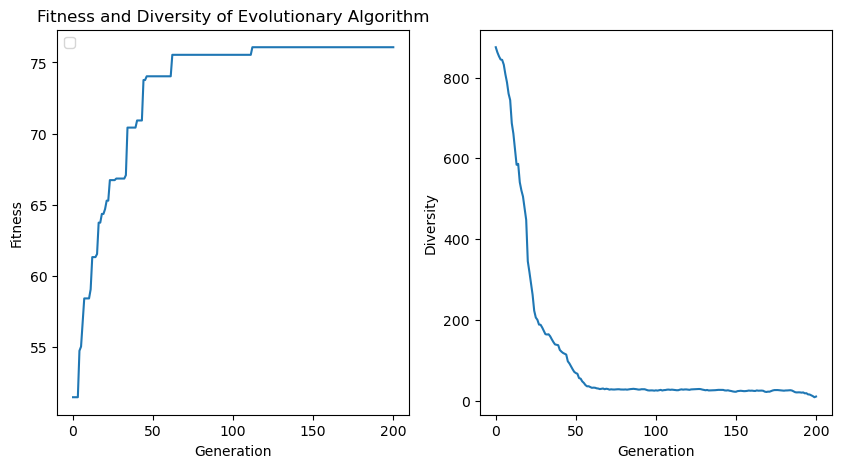

In [123]:
# plot the fitness and diversity in two separate subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(best_fitness_historic)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness and Diversity of Evolutionary Algorithm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diversity_historic)
plt.xlabel('Generation')
plt.ylabel('Diversity')